# TacotronF0の定量評価

ここではTacotronF0の定量評価を行う。具体的にはF0パターンを調査する。

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from scipy.io import wavfile,loadmat
from scipy.io.wavfile import read
from glob import glob
from os.path import join,basename
from pydub import AudioSegment

from tqdm import tqdm
from nnmnkwii import metrics

import layers
from  fastdtw  import fastdtw
from scipy.spatial.distance  import euclidean
from scipy import signal,stats,fftpack
import statistics

import IPython.display as ipd
from IPython.display import Audio,display,Image,display_png

In [2]:
def plot_data(data,figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')    

In [3]:
def load_lf0_vuv(path):
    with open(path,mode='rb') as f:
        lf0,vuv = pickle.load(f).values()
        return lf0,vuv

In [4]:
def load_wav_to_torch(path):
    sampling_rate, data = read(path)
    return torch.FloatTensor(data.astype(np.float32)), sampling_rate

In [5]:
def compute_melspec(data):
    audio_norm = data/32768
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    stft=layers.TacotronSTFT(1024, 200, 800,80, 16000, 0.0,8000.0)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0)
    return melspec

In [6]:
def get_spec(mel):
    stft = layers.TacotronSTFT(1024,200,800, sampling_rate=16000)
    mel_decompress = stft.spectral_de_normalize(mel)
    mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
    mel_decompress = mel_decompress.float()
    spec_from_mel_scaling = 1000
    spec_from_mel = torch.mm(mel_decompress[0], stft.mel_basis)
    spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
    spec_from_mel = spec_from_mel * spec_from_mel_scaling
    return spec_from_mel

In [7]:
def conpute_f0_from_spec(spec):
    _spec = spec[0].transpose(0,1)
    f0_from_ceps = []
    ceps = []
    peaks=[]
    for sp in _spec:
        sp[sp==0.0]= 1e-3
        log_sp = torch.log(torch.abs(sp)**2)
        cep = np.fft.ifft(log_sp)
        cep = cep[0:int(len(cep)/2)]
        ceps.append(cep)
        # f0の範囲が80hz-400hzになるように時間範囲を指定
        index_range = [ i  for i,x in enumerate(range(81),20)]
        peak = max(cep[index_range])
        peak_index = np.where(cep==peak)[0]
        f0 = 8000/peak_index
        f0_from_ceps.append(f0)
        f0 = [ f[0] for f in f0_from_ceps]
        peaks.append(peak)
    return  f0,ceps,peaks

In [8]:
def get_dtw(src,trg):
    _, path = fastdtw(src, trg, dist=euclidean)
    twf = np.array(path).T
    return twf[0],twf[1] 

In [9]:
def get_mfcc(mel):
    nceps=12
    mel=mel.transpose(0,1)
    for i, mspec in enumerate(mel):
        #メルケプストラムを離散コサイン変換　係数は12次まで取る
        ceps = fftpack.realtransforms.dct(mspec.float().data.cpu().numpy(), type=2, norm="ortho", axis=-1)[np.newaxis,:]
        if i == 0:
            mfcc = ceps
        else:
            mfcc =np.concatenate([mfcc,ceps[:nceps]],0)
    return torch.from_numpy(np.array(mfcc).astype(np.float32)).transpose(1,0)

In [10]:
def cal_mcd(cvt_mcc_dtw,trg_mcc_dtw):
    diff2sum = np.sum((cvt_mcc_dtw - trg_mcc_dtw)**2, 1)
    mcd = np.mean(10.0 / np.log(10.0) * np.sqrt(2 * diff2sum), 0)
    return mcd

In [11]:
def conpute_F0_RMSE(list_p,list_g):
    loss=[]
    for p , g in zip( list_p,list_g):
        #発話ごとに差の2乗和を計算
        loss.append(1200*np.sqrt(sum(torch.pow((torch.log2(g)-torch.log2(p)),2))/p.size(0)))
    return loss

In [12]:
base_dir = './DATA/005'

In [13]:
#標本化周波数
fs =16000

In [14]:
conpute = True

$F_{0}-RMSE = 1200\sqrt{\frac{1}{N_{v}}\sum_{n=1}^{N_{v}}(log_{2}f_{n}-log_{2}f'_{n})^2}$[cent]\
$N_{v}$:有声フレーム数\
f:有声区間のf0

#### 処理手順
        1.MFCCを基にDTWにより対応付けられたフレームのペアを獲得する。
        2.対応づけられたフレームのペアより両者が有声となるフレームを獲得する。
        3.対応づけられたF0系列から有声区間を取り出す。
        4.歪みを求める。

#### 教師データ

In [15]:
with open(join(base_dir,'tool/source_list'),'r')as f:
    yangpaths =[]
    for line in f:
        if   line.split('/') [-3] == 'WAV'  :
            yangpaths.append(line.replace('\n','').replace('WAV','yangsaf').replace('.wav','.mat'))
        else:
            yangpaths.append(line.replace('\n','').replace('WAV_df_fps','yangsaf').replace('.wav','.mat') )
with open(join(base_dir,'tool/source_list'),'r')as f:
    wavpaths =  [path.replace('\n','')  for path in f]

In [16]:
if conpute:
    gt_f0s = []
    gt_vuvs = [] 
    gt_mels = []  
    
    for yangpath ,wavpath in tqdm( zip(yangpaths,wavpaths)):
        mat = loadmat(yangpath)
        f0= mat['source']['f0'][0,0]
        vuv = mat['source']['vuv'][0,0]
        f0=f0.astype(np.float32)
        
        vuv=vuv.astype(np.float32)

        data,sr = load_wav_to_torch(wavpath)
        mel_spec = compute_melspec(data)
        if mel_spec.size(1) != f0.size:
            f0 = f0[(2.5*np.arange(0,mel_spec.size(1)-1)).astype(np.int)]
            f0 = np.append(f0,f0[-1])
            vuv = vuv[(2.5*np.arange(0,mel_spec.size(1)-1)).astype(np.int)]
            vuv = np.append(vuv,vuv[-1])
        f0 = torch.from_numpy(f0)
        vuv = torch.from_numpy(vuv)
        
        gt_f0s.append(f0)
        gt_vuvs.append(vuv)
        gt_mels.append(mel_spec)

100it [00:47,  2.09it/s]


#### Tacotron-F0

Tacotron-F0より得られたF0と真値よりRMSEを計算する

#### 出力されたVUV,F0

In [17]:
tf_f0_path = glob(join(base_dir,'Tacotronf0_130ksteps/lf0s_and_vuvs','*pickle'))
tf_f0_path.sort()

tf_mel_path = glob((join(base_dir,'Tacotronf0_130ksteps/mels','*npy')))
tf_mel_path.sort()

In [18]:
if conpute:
    gt_dtws_f=[]
    tf_dtws=[]
    vuv_match_rates_tf=[]
    for f0_path,mel_path,gt_f0,gt_vuv,gt_mel in tqdm(zip(tf_f0_path,tf_mel_path,gt_f0s,gt_vuvs,gt_mels)):
        #アライメント処理
        #mfcc
        mel = np.load(mel_path)
        mel = torch.from_numpy(np.array(mel).astype(np.float32)).clone()
        mfcc = get_mfcc(mel).transpose(0,1)
        mfccg = get_mfcc(gt_mel).transpose(0,1) 
        
        #DTW
        twf_src,twf_trg = get_dtw(mfcc,mfccg)

        #推定されたF0とVUV
        lf0, vuv = load_lf0_vuv(f0_path)
        f0 = torch.from_numpy(np.exp(lf0[twf_src]))
        vuv = torch.from_numpy(vuv[twf_src])
        
        #リファレンス
        gt_f0 = gt_f0[twf_trg]
        gt_vuv = gt_vuv[twf_trg]
        
        #どちらも有声であるフレームを獲得する
        v_index = [  i  for i, pare in enumerate (zip(vuv,gt_vuv)) if pare[0]==pare[1] and pare[0]==1]
        # vuv一致率 
        vuv_match_rate = sum([0 if v==vm else 1 for v,vm in zip(vuv,gt_vuv)])/vuv.size(0)*100
        vuv_match_rates_tf.append(vuv_match_rate )
        
        #有声区間のみにする。
        f0= f0[v_index]
        gt_f0 = gt_f0[v_index]
        
        gt_dtws_f.append(gt_f0)
        tf_dtws.append(f0)
        
    tf_F0_RMSE= conpute_F0_RMSE(tf_dtws,gt_dtws_f)
    print('中央値:{}[cent]'.format(statistics.median(tf_F0_RMSE)))
    print('VUV判定一致率:{}'.format(statistics.median(vuv_match_rates_tf)))

100it [00:09, 10.73it/s]


中央値:345.17864990234375[cent]
VUV判定一致率:9.801646951179661


#### スペクトログラムより得られたF0 vs yangsaf GT 

In [19]:
if conpute:
    gt_dtws_fm=[]
    tfm_dtws=[]
    vuv_match_rates_tfm=[]
    for mel_path,gt_mel,gt_f0,gt_vuv in tqdm(zip(tf_mel_path,gt_mels,gt_f0s,gt_vuvs)):
        
        #mfcc
        mel = np.load(mel_path)
        mel = torch.from_numpy(np.array(mel).astype(np.float32)).clone()
        mfcc = get_mfcc(mel).transpose(0,1)
        mfccg = get_mfcc(gt_mel).transpose(0,1) 
        
        #DTW
        twf_src,twf_trg = get_dtw(mfcc,mfccg)
        
        #推定されたF0とVUV
        spec = get_spec(mel.unsqueeze(0))
        f0,_,peaks = conpute_f0_from_spec(spec)
        f0=signal.medfilt(f0,5)
        peaks = torch.from_numpy(np.array(peaks).astype(np.float32)).clone()
        vuv=np.array([1.0 if peak>=0.01 else 0.0 for peak in peaks])
        f0 = torch.from_numpy(f0[twf_src])
        vuv = torch.from_numpy(vuv[twf_src])
            
        #リファレンス
        gt_f0 = gt_f0[twf_trg]
        gt_vuv = gt_vuv[twf_trg]    
        
        #どちらも有声であるフレームを獲得する
        v_index = [  i  for i, pare in enumerate (zip(vuv,gt_vuv)) if pare[0]==pare[1] and pare[0]==1]
        # vuv一致率 
        vuv_match_rate = sum([0 if v==vm else 1 for v,vm in zip(vuv,gt_vuv)])/vuv.size(0)*100
        vuv_match_rates_tfm.append(vuv_match_rate )
        
        #有声区間のみにする。
        f0= f0[v_index]
        gt_f0 = gt_f0[v_index]
        
        gt_dtws_fm.append(gt_f0)
        tfm_dtws.append(f0)
            
    tfm_F0_RMSE = conpute_F0_RMSE(tfm_dtws,gt_dtws_fm)
    print('中央値:{}[cent]'.format(statistics.median(tfm_F0_RMSE)))
    print('VUV判定一致率:{}'.format(statistics.median(vuv_match_rates_tfm)))

0it [00:00, ?it/s]/Users/hironishi/.conda/envs/tacotron/lib/python3.6/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
100it [00:44,  2.23it/s]

中央値:366.01150968436224[cent]
VUV判定一致率:23.525525123328645


#### Tacotron2

Tacotron2では基本周波数は出力されないため、ケプストラム法よりスペクトログラムからF0を推定する。

In [20]:
t2_mel_path = glob((join(base_dir,'Tacotron2_227ksteps/mels','*npy')))
t2_mel_path.sort()

In [21]:
if conpute:
    gt_dtws_2=[]
    t2_dtws=[]
    vuv_match_rates_t2=[]
    for mel_path,gt_mel,gt_f0,gt_vuv in tqdm(zip(t2_mel_path,gt_mels,gt_f0s,gt_vuvs)):
        
        #mfcc
        mel = np.load(mel_path)
        mel = torch.from_numpy(np.array(mel).astype(np.float32)).clone()
        mfcc = get_mfcc(mel).transpose(0,1)
        mfccg = get_mfcc(gt_mel).transpose(0,1) 
        
        #DTW
        twf_src,twf_trg = get_dtw(mfcc,mfccg)
        
        #推定されたF0とVUV
        spec = get_spec(mel.unsqueeze(0))
        f0,_,peaks = conpute_f0_from_spec(spec)
        f0=signal.medfilt(f0,5)
        peaks = torch.from_numpy(np.array(peaks).astype(np.float32)).clone()
        vuv=np.array([1.0 if peak>=0.01 else 0.0 for peak in peaks])
        f0 = torch.from_numpy(f0[twf_src])
        vuv = torch.from_numpy(vuv[twf_src])
            
        #リファレンス
        gt_f0 = gt_f0[twf_trg]
        gt_vuv = gt_vuv[twf_trg]    
        
        #どちらも有声であるフレームを獲得する
        v_index = [  i  for i, pare in enumerate (zip(vuv,gt_vuv)) if pare[0]==pare[1] and pare[0]==1]
        #vuv一致率
        vuv_match_rate = sum([0 if v==vm else 1 for v,vm in zip(vuv,gt_vuv)])/vuv.size(0)*100
        vuv_match_rates_t2.append(vuv_match_rate )
        
        
        #有声区間のみにする。
        f0= f0[v_index]
        gt_f0 = gt_f0[v_index]
        
        gt_dtws_2.append(gt_f0)
        t2_dtws.append(f0)
       
            
    t2_F0_RMSE = conpute_F0_RMSE(t2_dtws,gt_dtws_2)
    print('中央値:{}[cent]'.format(statistics.median(t2_F0_RMSE)))
    print('VUV判定一致率:{}'.format(statistics.median(vuv_match_rates_t2)))

0it [00:00, ?it/s]/Users/hironishi/.conda/envs/tacotron/lib/python3.6/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
100it [00:46,  2.14it/s]

中央値:474.78307229195735[cent]
VUV判定一致率:28.30796031205029


#### 調査に使用した評価音声の条件 003
各性別5名,言い淀みとフィラーを含まない100音声

#### TacotronF0 130kstep学習
#### 出力されたF0より求めた場合
中央値:330.4582214355469[cent]
#### F0&vuvをケプストラムより求めた場合
中央値:351.3866329074723[cent]
#### Tacotron2 130kstep学習
中央値:367.78043262805863[cent]
#### Tacotron2 227kstep学習
中央値:375.760827168634[cent]



#### 調査に使用した評価音声の条件 002
各性別50名,言い淀みとフィラーを含む：含まない=1:1の100音声

#### TacotronF0 13kstep学習
#### 出力されたF0より求めた場合
中央値:340.4158020019531[cent]
#### F0&vuvをケプストラムより求めた場合
中央値:358.41509034067303[cent]
#### Tacotron2 227kstep学習
中央値:431.6830528356909[cent]




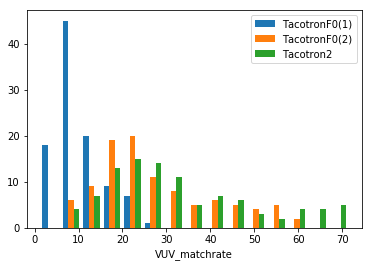

In [22]:
if conpute:
    labels=['TacotronF0(1)','TacotronF0(2)','Tacotron2']
    plt.hist([vuv_match_rates_tf, vuv_match_rates_tfm, vuv_match_rates_t2],bins=15,label=labels)
    plt.xlabel('VUV_matchrate')
    plt.legend()
    #plt.savefig('F0-RMSE')

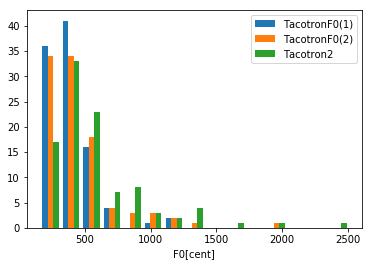

In [23]:
if conpute:
    labels=['TacotronF0(1)','TacotronF0(2)','Tacotron2']
    plt.hist([tf_F0_RMSE,tfm_F0_RMSE,t2_F0_RMSE],bins=15,label=labels)
    plt.xlabel('F0[cent]')
    plt.legend()
    #plt.savefig('F0-RMSE')

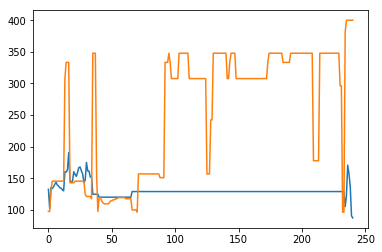

In [24]:
plt.plot(gt_dtws_2[1])
plt.plot(t2_dtws[1])

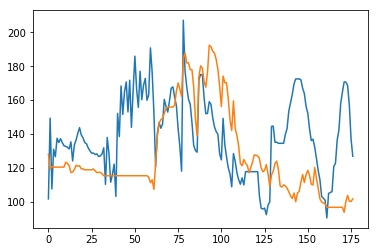

In [25]:
plt.plot(gt_dtws_f[1])
plt.plot(tf_dtws[1])

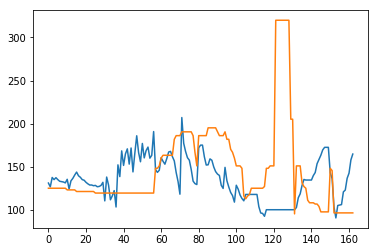

In [26]:
plt.plot(gt_dtws_fm[1])
plt.plot(tfm_dtws[1])

検定は

    ・等分散の検定
    ・ガンマ分布

のどちらか
今回は等分散の検定で行う。

$H_0$ :両モデルの分散は等しい,$H_1$ :両モデルの分散は異なる
検定にはscipy.stats.bartlett()をもちいる

検定の結果、p値が$0.173$であり0.05を上回るため$H_0$は棄却できない\
次に、2群間のt検定を行なった結果\
Ttest_indResult(statistic=5.981377666233164, pvalue=1.0182857916646957e-08)\
であり、有意に差があることがわかった。

### F0とスペクトログラムの整合性

#### Tacotron-F0

100it [00:37,  2.68it/s]


中央値:70.34248352050781cent
平均VUV判定不一致率:20.057471264367816


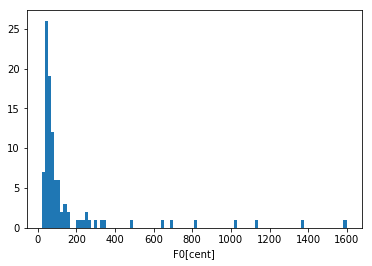

In [27]:
if conpute:
    lf0s = []
    lf0_ms = []
    loss=[]
    vuv_match_rates = []
    for f0_path,mel_path in tqdm(zip(tf_f0_path,tf_mel_path )):
        lf0, vuv=load_lf0_vuv(f0_path)
        vuv = torch.from_numpy(vuv)
        lf0 = torch.from_numpy(np.log2(np.exp(lf0)))*vuv
        
        mel = np.load(mel_path)
        mel =  torch.from_numpy(np.array(mel).astype(np.float32)).clone()
        spec = get_spec(mel.unsqueeze(0))
        f0_m,_ ,peaks= conpute_f0_from_spec(spec)
        f0_m=signal.medfilt(f0_m,5)
        vuv_m=torch.from_numpy(np.array( [1.0 if peak>=0.01  else 0.0 for peak in peaks]).astype(np.float32))
        lf0_m = np.log2(f0_m)
        lf0_m = torch.from_numpy(np.array(lf0_m).astype(np.float32))
        lf0_m = lf0_m*vuv
        lf0s.append(lf0)
        lf0_ms.append(lf0_m)
        loss.append(1200*torch.sqrt(torch.nn.MSELoss()(lf0_m,lf0)))
        #vuv一致率
        vuv_match_rate = sum([0 if v==vm else 1 for v,vm in zip(vuv,vuv_m)])/vuv.size(0)*100
        vuv_match_rates.append(vuv_match_rate)
        
    print('中央値:{}cent'.format(statistics.median(loss))) 
    print('平均VUV判定不一致率:{}'.format(statistics.median(vuv_match_rates)))
    plt.hist(loss,bins=100)
    plt.xlabel('F0[cent]')
    #plt.savefig('./Consistency')

## 確認

In [28]:
mel=np.load(t2_mel_path[71])
mel =  torch.from_numpy(np.array(mel).astype(np.float32)).clone()
spec = get_spec(mel.unsqueeze(0))
data,sr = load_wav_to_torch(wavpaths[71])
mel_g= compute_melspec(data) 

In [29]:
f0,ceps,peaks = conpute_f0_from_spec(spec) 

In [30]:
#melからmfccを得る 
mfcc = get_mfcc(mel)
mfcc_g = get_mfcc(mel_g)
# DTWを行い配列を得る。
twf = get_dtw(mfcc_g.transpose(0,1),mfcc.transpose(0,1))

In [31]:
f0,ceps,peaks = conpute_f0_from_spec(spec)
f0= signal.medfilt(f0,5)
f0=np.array(f0)

mat = loadmat(yangpaths[71])
f0_g= mat['source']['f0'][0,0]
vuv_g =mat['source']['vuv'][0,0]
f0_g=f0_g.astype(np.float32)

In [32]:
vuv = np.array([ x[0]  for x in vuv_g])

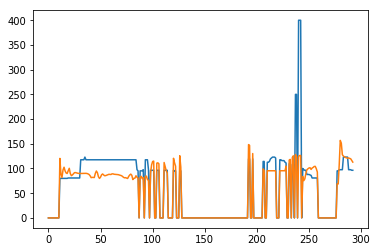

In [33]:
plt.plot(f0[twf[1]]*vuv[twf[0]])
plt.plot(f0_g[twf[0]]*vuv_g[twf[0]])

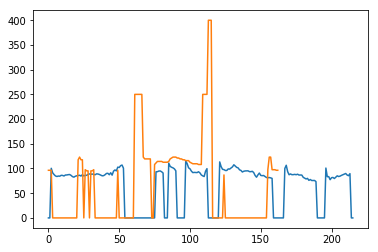

In [34]:
f0,ceps,peaks = conpute_f0_from_spec(spec)
vuv_p= [1.0 if peak>=0.01  else 0.0 for peak in peaks]
f0= signal.medfilt(f0,5)
f0 = f0*np.array(vuv_p)
lf0, vuv=load_lf0_vuv(tf_f0_path[71])
plt.plot(np.exp(lf0)*vuv)
plt.plot(f0)

### 分析再合成

In [35]:
syn = False

In [36]:
if conpute and syn:
    from audio_processing import griffin_lim
    from scipy.io.wavfile  import write
    out_dir = join(base_dir,'Grand_truth_griffin_lim')
    os.makedirs(out_dir,exist_ok=True)
    stft = layers.TacotronSTFT(1024,200,800, sampling_rate=16000)
    for i, mel in tqdm(enumerate(gt_mels)):
        spec = get_spec(mel.unsqueeze(0))
        audio = griffin_lim(torch.autograd.Variable(spec[:, :, :-1]), stft.stft_fn, 100)
        audio = audio.squeeze()
        audio = audio.data.cpu().numpy()
        audio = audio/np.max(np.abs(audio))
        write(join(out_dir,'text_{}.wav'.format(str(i).zfill(3))),16000,audio)

In [37]:
a = torch.from_numpy(np.array([2,3,4]).astype(np.float32))
b = torch.from_numpy(np.array([3,6,7]).astype(np.float32))
los = torch.sqrt(torch.nn.MSELoss()(a,b))
print(los)
print(np.sqrt(sum(torch.pow((a-b) ,2))/a.size(0)))

tensor(2.5166)
tensor(2.5166)
